Histograms
==========
In scientific python, histograms seem to be considered as a plot style, on equal footing with, e.g. scatter plots.
It may well be that HEP is the only place where users need to plot *pre-binned* data, and thus must use histograms as persistent objects representing reduced data.  This notebook will discuss a few ways that such objects can be manipulated.

A histogram object roughly goes through three stages in its life:
   - Filling
   - Transformation (projection, rebinning, integrating)
   - Plotting

## Filling
Let's start with filling.  We'll use a random distribution [near and dear](https://en.wikipedia.org/wiki/ARGUS_distribution) to of b and c factory physicists.

In [1]:
import numpy as np
from scipy.stats import argus

vals = argus(chi=.5).rvs(size=1000)

hist = np.histogram(vals)
print(hist)

(array([ 18,  47,  70,  89, 105, 139, 144, 153, 138,  97]), array([0.01056044, 0.10921388, 0.20786733, 0.30652078, 0.40517423,
       0.50382768, 0.60248113, 0.70113458, 0.79978803, 0.89844147,
       0.99709492]))


So we're done, right?
Probably not: we have more than 1000 events, and probably need to use some map-reduce paradigm to fill the histogram because we can't keep all 1 billion `vals` in memory.  So we need two things: a binning, so that all histograms that were independently created can be added, and the ability to add two histograms.

In [2]:
binning = np.linspace(0, 1, 50)

def add_histos(h1, h2):
    h1sumw, h1binning = h1
    h2sumw, h2binning = h2
    if h1binning.shape == h2binning.shape and np.all(h1binning==h2binning):
        return h1sumw+h2sumw, h1binning
    else:
        raise ValueError("The histograms have inconsistent binning")


In [3]:
vals2 = argus(chi=.5).rvs(size=1000)

hist1 = np.histogram(vals, bins=binning)
hist2 = np.histogram(vals, bins=binning)

hist = add_histos(hist1, hist2)
print(hist)

(array([ 2,  6,  4,  6, 14, 12, 12, 22, 14, 34, 28, 20, 30, 34, 32, 22, 38,
       28, 44, 50, 44, 44, 38, 54, 56, 46, 64, 38, 62, 58, 56, 58, 68, 62,
       66, 60, 64, 54, 70, 64, 48, 64, 38, 74, 68, 52, 28, 30, 20]), array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ]))


So now we have everything we need to make our own TH1, from a filling perspective.

In [4]:
class myTH1:
    def __init__(self, binning):
        self._binning = binning
        self._sumw = np.zeros(binning.size - 1)
    
    def fill(self, values, weights=None):
        sumw, _ = np.histogram(values, bins=self._binning, weights=weights)
        self._sumw += sumw
    
    def __add__(self, other):
        if not isinstance(other, myTH1):
            raise ValueError
        if not np.array_equal(other._binning, self._binning):
            raise ValueError("The histograms have inconsistent binning")
        out = myTH1(self._binning)
        out._sumw = self._sumw + other._sumw
        return out

In [5]:
binning = np.linspace(0, 1, 50)

h1 = myTH1(binning)
h1.fill(vals)

h2 = myTH1(binning)
h2.fill(vals2)

h = h1 + h2
print(h._sumw)

[ 2.  5.  4. 10. 12. 16.  9. 19. 17. 35. 24. 17. 29. 30. 31. 27. 41. 29.
 45. 43. 45. 50. 46. 55. 54. 46. 58. 51. 56. 59. 57. 58. 62. 56. 65. 62.
 75. 59. 61. 74. 59. 53. 53. 62. 67. 40. 28. 27. 17.]


Homework: add `sumw2` support.

Of course, we might want multidimensional histograms.  There is `np.histogramdd`:

In [6]:
xyz = np.random.multivariate_normal(mean=[1, 3, 7], cov=np.eye(3), size=10000)

xbins = np.linspace(-10, 10, 20)
ybins = np.linspace(-10, 10, 20)
zbins = np.linspace(-10, 10, 20)
hnumpy = np.histogramdd(xyz, bins=(xbins, ybins, zbins))

but we are becoming challenged by book-keeping of the variables.
The histogram utility in Coffea is designed to simplify this operation, and the eventual successor (for filling purposes) [boost-histogram](https://github.com/scikit-hep/boost-histogram#usage) has similar syntax.

In [7]:
import fnal_column_analysis_tools.hist as hist

hfcat = hist.Hist("Counts",
                  hist.Cat("sample", "sample name"),
                  hist.Bin("x", "x value", 20, -10, 10),
                  hist.Bin("y", "y value", 20, -10, 10),
                  hist.Bin("z", "z value", 20, -10, 10),
                 )

hfcat.fill(sample="sample 1", x=xyz[:,0], y=xyz[:,1], z=xyz[:,2])

# suppose we have another sample of xyz values
xyz_sample2 = np.random.multivariate_normal(mean=[1, 3, 7], cov=np.eye(3), size=10000)

# additionally, lets assume entries in sample 2 have weight equal to atan(distance from origin)
weight = np.arctan(np.sqrt(np.power(xyz_sample2, 2).sum(axis=1)))

# weight is a reserved keyword in Hist
hfcat.fill(sample="sample 2", x=xyz_sample2[:,0], y=xyz_sample2[:,1], z=xyz_sample2[:,2], weight=weight)

print(hfcat)

<Hist (sample,x,y,z) instance at 0x111335550>


In [8]:
# For more details, look at:
# help(hist.Hist)
# help(hist.Bin)
# help(hist.Cat)

## Transformation

Here are a few examples of transformations on multidimensional histograms in Coffea.  For each, the docstring (`help(function)` or shift+tab in Jupyter) provides useful info.

In [9]:
# sum all x bins within nominal range (-10, 10)
hfcat.sum("x", overflow='none')

<Hist (sample,y,z) instance at 0x1113250f0>

There is some analog to fancy array slicing for histogram objects, which is supported (with reasonable consistency) in Coffea, where the slice boundaries are physical axis values, rather than bin indices.  All values outside the slice range are merged into overflow bins.

For a lengthy discussion on possible slicing syntax for the future, see [boost-histogram#35](https://github.com/scikit-hep/boost-histogram/issues/35).

In [10]:
sliced = hfcat[:,0:,4:,0:]
display(sliced)
display(sliced.identifiers("y", overflow='all'))

<Hist (sample,x,y,z) instance at 0x111325c18>

[<Interval ((-inf, 4)) instance at 0x1113259b0>,
 <Interval ([4, 5)) instance at 0x1113130f0>,
 <Interval ([5, 6)) instance at 0x1113130b8>,
 <Interval ([6, 7)) instance at 0x111313d30>,
 <Interval ([7, 8)) instance at 0x111313e48>,
 <Interval ([8, 9)) instance at 0x111313d68>,
 <Interval ([9, 10)) instance at 0x111313080>,
 <Interval ([10, inf)) instance at 0x1113135f8>]

In [11]:
# integrate y bins from -2 to +10
hfcat.project("y", slice(0, 10))

<Hist (sample,x,z) instance at 0x111313198>

In [12]:
# rebin z axis by providing a new axis definition
hfcat.rebin("z", hist.Bin("znew", "rebinned z value", [-10, -6, 6, 10]))

<Hist (sample,x,y,znew) instance at 0x111325978>

In [13]:
# merge categorical axes
mapping = {
    'all samples': ['sample 1', 'sample 2'],
    'just sample 1': ['sample 1'],
}
hfcat.group(hist.Cat("cat", "new category"), "sample", mapping)

<Hist (cat,x,y,z) instance at 0x117023198>

In [14]:
# scale entire histogram by 3 (in-place)
hfcat.scale(3.)

In [15]:
# scale samples by different values
scales = {
    'sample 1': 1.2,
    'sample 2': 0.2,
}
hfcat.scale(scales, axis='sample')

In [16]:
# useful debugging tool: print bins, aka 'identifiers'
display(hfcat.identifiers('sample'))
display(hfcat.identifiers('x'))

[<StringBin (sample 1) instance at 0x116fc4cc0>,
 <StringBin (sample 2) instance at 0x116fc4d30>]

[<Interval ([-10, -9)) instance at 0x1113355f8>,
 <Interval ([-9, -8)) instance at 0x116f67da0>,
 <Interval ([-8, -7)) instance at 0x116fadb00>,
 <Interval ([-7, -6)) instance at 0x116fadb38>,
 <Interval ([-6, -5)) instance at 0x116fadbe0>,
 <Interval ([-5, -4)) instance at 0x116fad860>,
 <Interval ([-4, -3)) instance at 0x116fad898>,
 <Interval ([-3, -2)) instance at 0x116fbbe48>,
 <Interval ([-2, -1)) instance at 0x116fbbef0>,
 <Interval ([-1, 0)) instance at 0x116fbbf28>,
 <Interval ([0, 1)) instance at 0x116fbbf60>,
 <Interval ([1, 2)) instance at 0x116fbbf98>,
 <Interval ([2, 3)) instance at 0x116fbbfd0>,
 <Interval ([3, 4)) instance at 0x116fc4048>,
 <Interval ([4, 5)) instance at 0x116fc4080>,
 <Interval ([5, 6)) instance at 0x116fc40b8>,
 <Interval ([6, 7)) instance at 0x116fc40f0>,
 <Interval ([7, 8)) instance at 0x116fc4128>,
 <Interval ([8, 9)) instance at 0x116fc4160>,
 <Interval ([9, 10)) instance at 0x116fc4198>]

In [17]:
# bin contents are accessed using values
hfcat.sum('x', 'y').values(sumw2=False)

{('sample 1',): array([    0. ,     0. ,     0. ,     0. ,     0. ,     0. ,     0. ,
            0. ,     0. ,     0. ,     0. ,     0. ,     0. ,    75.6,
          709.2,  4698. , 12625.2, 11980.8,  4960.8,   889.2]),
 ('sample 2',): array([   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,   10.79267708,  172.58671521, 1170.69360078,
        2912.65884966, 3039.27895152, 1167.41282979,  171.12312075])}

## Plotting
The most integrated plotting utility in the scientific python ecosystem, by far, is [matplotlib](https://matplotlib.org/).  However, as we will see, it is not tailored to HEP needs.  To facilitate the transition, there is a developing package called [mpl-hep](https://github.com/nsmith-/mpl-hep#mpl-hep).  Meanwhile, Coffea tools provide several convenience functions to aid in plotting `Hist` objects.

Let's start by looking at basic mpl histogramming.

In [18]:
# Jupyter display backends for matplotlib: nbagg, inline, etc.
%matplotlib inline
import matplotlib.pyplot as plt

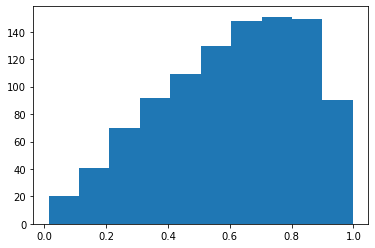

In [19]:
vals = argus(chi=.5).rvs(size=1000)

# notice the semicolon, which prevents display of the return values
plt.hist(vals);

Suppose we want to plot pre-binned data, for example from our earlier `np.histogram` usage.  Here we start running into the edge of typical mpl usage.  As mentioned before, apparently HEP is the only regular user of pre-binned histograms.

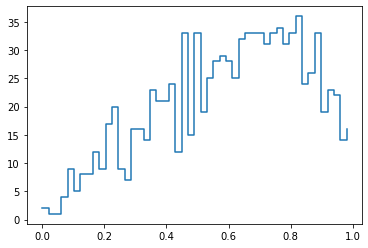

In [20]:
binning = np.linspace(0, 1, 50)

h1vals, h1bins = np.histogram(vals, bins=binning)
plt.step(x=h1bins[:-1], y=h1vals, where='post');

Coffea utilities include a plotting package to aid in displaying pre-binned histograms.  Here are a small set of example plots that can be made using this utility.  More examples can be found in [this notebook](https://github.com/CoffeaTeam/fnal-column-analysis-tools/blob/master/binder/plotting-demo.ipynb).

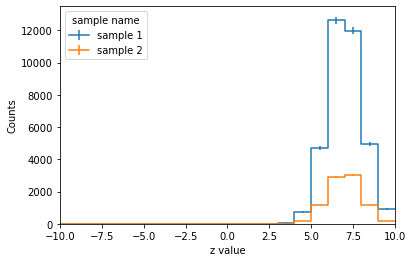

In [21]:
import fnal_column_analysis_tools.hist.plot as plot

plot.plot1d(hfcat.sum("x", "y"), overlay='sample');

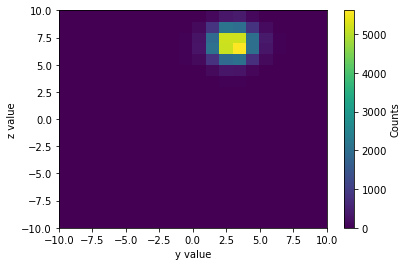

In [22]:
plot.plot2d(hfcat.sum('x', 'sample'), xaxis='y');

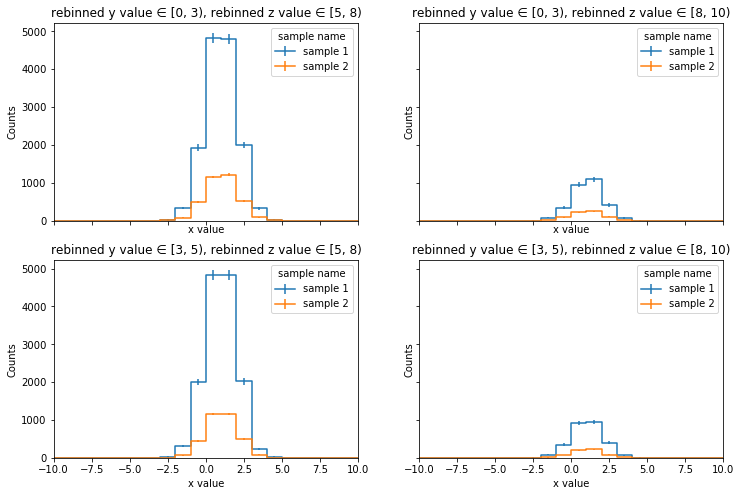

In [23]:
# make coarse binned hist and look at several distributions
hnew = (hfcat.rebin("y", hist.Bin("ynew", "rebinned y value", [0, 3, 5]))
        .rebin("z", hist.Bin("znew", "rebinned z value", [5, 8, 10]))
       )

plot.plotgrid(hnew, row='ynew', col='znew', overlay='sample');

/Users/ncsmith/miniconda3/envs/lpchats2019-uproot-awkward/lib/python3.7/site-packages/fnal_column_analysis_tools/hist/plot.py:290: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


(-10, 10)

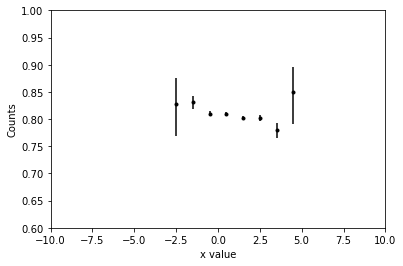

In [24]:
numerator = hfcat.project('sample', 'sample 1').sum('y', 'z')
denominator = hfcat.sum('sample', 'y', 'z')

numerator.title = r'$\epsilon$'
fig, ax, _ = plot.plotratio(num=numerator,
                            denom=denominator,
                            error_opts={'color': 'k', 'marker': '.'},
                            unc='clopper-pearson'
                           )
ax.set_ylim(0.6, 1.)
ax.set_xlim(-10, 10)